# Look at the overview scans
Let's see what we did there.

In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import pandas
import numpy
from tqdm import notebook
from itkwidgets import view  # 3d viewer
import imageio
import dask
import dask.array as da
import dask_image.imread
from distributed import Client
client = Client()
from numcodecs import Blosc

In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [3]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [5]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200  # Increase dpi

In [6]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'


The validate_legend_loc function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [7]:
# Display all plots identically
lines = 4
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [124]:
# Different locations if running either on Linux or Windows
if 'anaklin25' in platform.node():
    FastSSD = True
else:
    FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Volumes/2TBSSD/')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from /Volumes/2TBSSD/Hearts Melly


In [125]:
glob.glob(os.path.join(Root))

['/Volumes/2TBSSD/Hearts\xa0Melly']

In [126]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [127]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [128]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [129]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [130]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [131]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        grayvalue = numpy.nan
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [174]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [175]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, 'Rat[678T]*', '*'))

In [176]:
# Get rid of all non-folders
for c, i in Data.iterrows():
    if not os.path.isdir(i.Folder):
        Data.drop([c], inplace=True)
Data.reset_index(drop=True, inplace=True)

In [177]:
try:
    Data['Folder'][0]
except IndexError:
    print(10 * '\n')
    print('Please mount the Fast SSD!')
    print(10 * '\n')

In [178]:
Data['Sample'] = [os.path.basename(os.path.dirname(f)) for f in Data['Folder']]
Data['Scan'] = [os.path.basename(f) for f in Data['Folder']]
Data['SampleNameLength'] = [len(sn) for sn in Data['Sample']]
Data['ScanNameLength'] = [len(sn) for sn in Data['Scan']]

In [179]:
print('We habe %s scans to work with' % len(Data))

We habe 37 scans to work with


In [180]:
# Get log files of all the scans
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]

In [181]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]

In [182]:
# Did we reconstruct them equally?
Data[['Sample', 'Voxelsize', 'Filter', 'Exposuretime', 'Grayvalue', 'RingartefactCorrection', 'BeamHardeningCorrection']]

,Sample,Voxelsize,Filter,Exposuretime,Grayvalue,RingartefactCorrection,BeamHardeningCorrection
0,Rat60,10.000036,Al 1mm,2349,0.070000,14,0
1,Rat60,10.000036,Cu 0.11mm,3455,0.200000,14,10
2,Rat69,10.000036,Cu 0.11mm,3455,0.200000,14,10
3,Rat69,10.000036,Al 1mm,2349,0.070000,14,0
4,Rat61,10.000036,Cu 0.11mm,3455,0.052139,14,10
5,Rat61,10.000036,Al 1mm,2349,0.070000,14,0
6,Rat62,10.000036,Cu 0.11mm,3455,0.200000,14,10
7,Rat62,10.000036,Al 1mm,2349,0.070000,14,0
8,Rat63,10.000036,Al 1mm,2349,0.070000,14,0
9,Rat64,10.000036,Cu 0.11mm,3455,0.200000,14,10


In [183]:
print(Data['Voxelsize'].unique())
print(Data['Exposuretime'].unique())
print(Data['Filter'].unique())
print(Data['Grayvalue'].unique())
print(Data['RingartefactCorrection'].unique())
print(Data['BeamHardeningCorrection'].unique())

[10.000036 21.599949  9.919951]
[2349 3455 1593 3276 2330]
['Al 1mm' 'Cu 0.11mm']
[0.07     0.2      0.052139 0.1      0.066   ]
[14]
[ 0 10]


In [184]:
# Save to XLS sheet for Ludovic
Data[['Folder', 'Sample', 'Scan', 'Voxelsize']].to_excel('Voxelsizes.xlsx')

In [185]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f,
                                                         'rec',
                                                         '*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [186]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet, we remove it from our data temporarily' % sample)
    Data = Data[Data['Number of reconstructions'] > 0]
    Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

Rat70 has not been reconstructed yet, we remove it from our data temporarily
Rat79 has not been reconstructed yet, we remove it from our data temporarily
Rat79 has not been reconstructed yet, we remove it from our data temporarily
Rat79 has not been reconstructed yet, we remove it from our data temporarily
Rat80 has not been reconstructed yet, we remove it from our data temporarily
Rat80 has not been reconstructed yet, we remove it from our data temporarily
Rat80 has not been reconstructed yet, we remove it from our data temporarily
Rat80b has not been reconstructed yet, we remove it from our data temporarily
Rat81 has not been reconstructed yet, we remove it from our data temporarily
Rat81 has not been reconstructed yet, we remove it from our data temporarily
Rat81 has not been reconstructed yet, we remove it from our data temporarily
Rat82 has not been reconstructed yet, we remove it from our data temporarily
Rat82 has not been reconstructed yet, we remove it from our data temporaril

In [187]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %03s reconstructions in %s/%s' % (c + 1,
                                                             len(Data),
                                                             row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                             row['Number of reconstructions'],
                                                             os.path.basename(row['Folder']),
                                                             'rec'))

 1/18: Rat60 has 2795 reconstructions in overview/rec
 2/18: Rat60 has 2757 reconstructions in cu_10um/rec
 3/18: Rat69 has 2431 reconstructions in cu_10um/rec
 4/18: Rat69 has 2238 reconstructions in overview/rec
 5/18: Rat61 has 2757 reconstructions in cu_10um/rec
 6/18: Rat61 has 2647 reconstructions in overview/rec
 7/18: Rat62 has 2757 reconstructions in cu_10um/rec
 8/18: Rat62 has 2878 reconstructions in overview/rec
 9/18: Rat63 has 2309 reconstructions in overview/rec
10/18: Rat64 has 2288 reconstructions in cu_10um/rec
11/18: Rat64 has 2426 reconstructions in overview/rec
12/18: Rat65 has 2188 reconstructions in cu_10um/rec
13/18: Rat65 has 2338 reconstructions in overview/rec
14/18: Rat66 has 2454 reconstructions in overview/rec
15/18: Rat67 has 2203 reconstructions in cu_10um/rec
16/18: Rat67 has 2172 reconstructions in overview/rec
17/18: Rat68 has 2233 reconstructions in cu_10um/rec
18/18: Rat68 has 2558 reconstructions in overview/rec


In [188]:
# Convert reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                       len(Data),
                                                                       row['Number of reconstructions'],
                                                                       row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*.png'))
        Reconstructions.rechunk(200).to_zarr(row['OutputNameRec'],
                                             overwrite=True,
                                             compressor=Blosc(cname='zstd',
                                                              clevel=5,
                                                              shuffle=Blosc.BITSHUFFLE))

 1/18: Reading 2795 reconstructions and saving to /Rat60/overview/Rat60_rec.zarr



KeyboardInterrupt: 

In [172]:
# Load the reconstructions a zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

ArrayNotFoundError: array not found at path %r' ''

In [44]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [45]:
def cropper(image,
            despeckle=True,
            verbose=False,
            threshold=50):
    import skimage.morphology
    import scipy
    '''Crop array to biggest item in it'''
    dimensions = len(image.shape)
    if verbose:
        print('Cropping %s-dimensional image' % dimensions)
    # Threshold
    thresholded = image > threshold
    if despeckle:
        if verbose:
            print('Removing small objects')
        despeckled = skimage.util.apply_parallel(skimage.morphology.remove_small_objects,
                                                 thresholded,
                                                 extra_keywords={'min_size': 10**dimensions},
                                                 chunks=[15,15,15])
    # Find biggest object
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.find_objects.html
    if verbose:
        print('Finding objects')
    if despeckle:
        cropdimensions = scipy.ndimage.find_objects(despeckled)[0]
    else:
        cropdimensions = scipy.ndimage.find_objects(thresholded)[0]
    if verbose:
        print('Cutting the image down to')
        for c, cd in enumerate(cropdimensions):
            print('\t- %s: %s' % (c, cd))
        if dimensions > 2:
            # Calculate cardinal direction MIPs
            MIPs = [image.max(axis=d) for d, direction in notebook.tqdm(enumerate(directions),
                                                                                  desc='Calculating MIPs',
                                                                                  total=len(directions))]
            for d, direction in enumerate(directions):
                plt.subplot(1, dimensions, d + 1)
                plt.imshow(MIPs[d], alpha=0.618)
                plt.imshow(dask.array.ma.masked_less(MIPs[d]>threshold, 1),
                           alpha=0.309,
                           cmap='viridis_r')
                if d == 0:
                    plt.axhline(cropdimensions[1].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[1].start)
                    plt.axhline(cropdimensions[1].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[1].stop)
                    plt.axvline(cropdimensions[2].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[2].start)
                    plt.axvline(cropdimensions[2].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[2].stop)
                elif d == 1:
                    plt.axhline(cropdimensions[0].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[0].start)
                    plt.axhline(cropdimensions[0].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[0].stop)
                    plt.axvline(cropdimensions[2].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[2].start)
                    plt.axvline(cropdimensions[2].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[2].stop)                    
                elif d == 2:
                    plt.axhline(cropdimensions[0].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[0].start)
                    plt.axhline(cropdimensions[0].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[0].stop)
                    plt.axvline(cropdimensions[1].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[1].start)
                    plt.axvline(cropdimensions[1].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[1].stop)                                        
                plt.title('%s MIP' % direction)
                plt.legend(loc='lower right')
        else:
            plt.subplot(121)
            plt.imshow(image, alpha=0.618)
            plt.imshow(dask.array.ma.masked_less(thresholded, 1), alpha=0.618, cmap='viridis_r')
            plt.axhline(cropdimensions[0].start, c=seaborn.color_palette()[0], label=cropdimensions[0].start)
            plt.axhline(cropdimensions[0].stop, c=seaborn.color_palette()[1], label=cropdimensions[0].stop)
            plt.axvline(cropdimensions[1].start, c=seaborn.color_palette()[2], label=cropdimensions[1].start)
            plt.axvline(cropdimensions[1].stop, c=seaborn.color_palette()[3], label=cropdimensions[1].stop)
            plt.title('Original image with thresholded overlay')
            plt.legend(loc='lower right')
            plt.subplot(122)
            plt.imshow(image[cropdimensions])
            plt.title('Output')
        plt.show()
    if verbose:
        print('Cropped image from %s to %s' % (image.shape, image[cropdimensions].shape))
        print(cropdimensions)
    return(image[cropdimensions])

In [46]:
# # Test cropping function
# img = Reconstructions[-1]
# Cropped = cropper(img, verbose=True, despeckle=True, threshold=55)
# for c, direction in enumerate(directions):
#     plt.subplot(1,3,c+1)    
#     if 'Axial' in direction:
#         plt.imshow(Cropped[Cropped.shape[0] // 2])
#     if 'Sagittal' in direction:
#         plt.imshow(Cropped[:, Cropped.shape[1] // 2, :])
#     if 'Coronal' in direction:
#         plt.imshow(Cropped[:, :, Cropped.shape[2] // 2])

In [47]:
# cropper(Reconstructions[3], verbose=True)

 13/ 30: Saving to \Rat79\cu_10um\Rat79_rec_crop.zarr
Cropping 3-dimensional image
Removing small objects
Finding objects
Cutting the image down to
	- 0: slice(23, 2382, None)
	- 1: slice(483, 1882, None)
	- 2: slice(588, 2171, None)


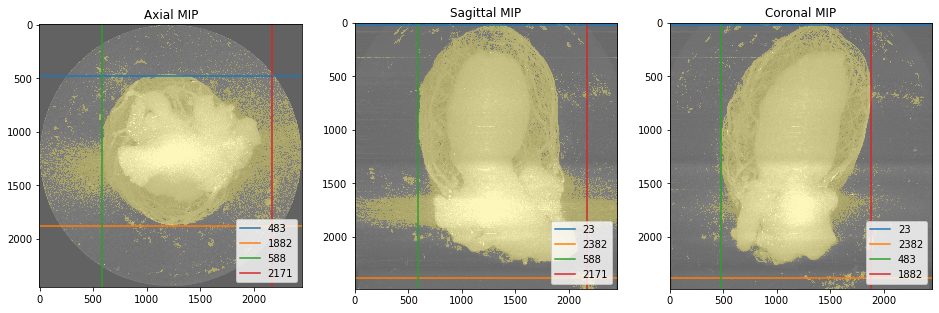

Cropped image from (2484, 2452, 2452) to (2359, 1399, 1583)
(slice(23, 2382, None), slice(483, 1882, None), slice(588, 2171, None))
 16/ 30: Saving to \Rat80\cu_10um\Rat80_rec_crop.zarr
Cropping 3-dimensional image
Removing small objects
Finding objects
Cutting the image down to
	- 0: slice(225, 2215, None)
	- 1: slice(648, 1930, None)
	- 2: slice(349, 1845, None)


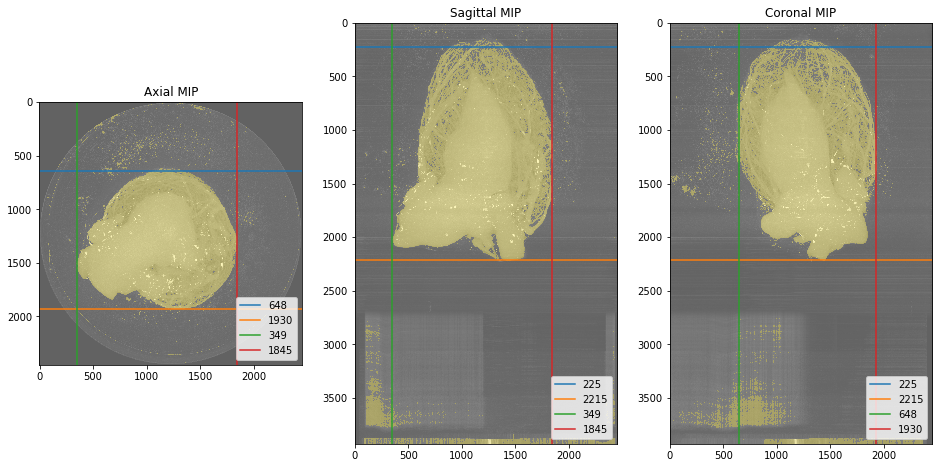

Cropped image from (3931, 2452, 2452) to (1990, 1282, 1496)
(slice(225, 2215, None), slice(648, 1930, None), slice(349, 1845, None))
 27/ 30: Saving to \Rat84\cu_10um\Rat84_rec_crop.zarr
Cropping 3-dimensional image
Removing small objects
Finding objects
Cutting the image down to
	- 0: slice(123, 2033, None)
	- 1: slice(523, 2298, None)
	- 2: slice(20, 2114, None)


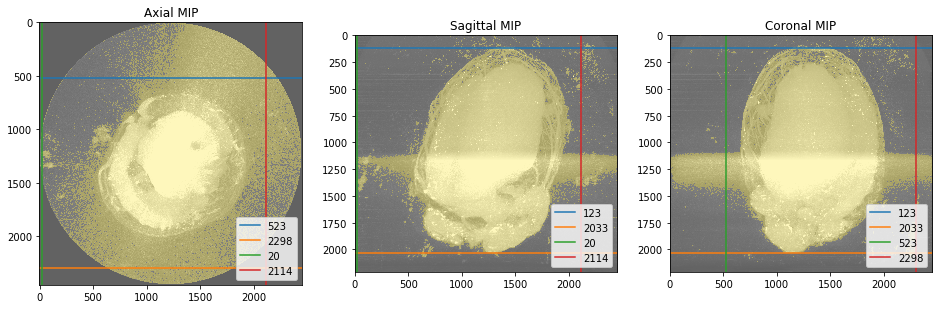

Cropped image from (2210, 2452, 2452) to (1910, 1775, 2094)
(slice(123, 2033, None), slice(523, 2298, None), slice(20, 2114, None))



In [48]:
# Crop the reconstructions and save them out as .zarr files, too
Data['OutputNameRecCrop'] = [os.path.join(f, sample + '_rec_crop.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving cropped samples to .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRecCrop']):
        print('%3s/%3s: Saving to %s' % (c + 1,
                                         len(Data),
                                         row['OutputNameRecCrop'][len(Root):]))
        # Calculate crop with our function and directly write to ZARR file
        cropper(Reconstructions[c],
                verbose=True,
                despeckle=True).to_zarr(row['OutputNameRecCrop'],
                                        overwrite=True,
                                        compressor=Blosc(cname='zstd',
                                                         clevel=3,
                                                         shuffle=Blosc.BITSHUFFLE))  

In [49]:
# Load the cropped zarr arrays as reconstructions
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRecCrop']]

In [ ]:
# Save out cropped rec slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out cropped recs',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'rec_crop'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(Reconstructions[c]),
                                total=len(Reconstructions[c]),
                                desc=os.path.join(row.Sample, os.path.basename(row.Folder)),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'rec_crop', str(row.Sample) + '_rec_crop_%08d.png' % d)
        if not os.path.exists(filename):
            imageio.imsave(filename, rec)

In [ ]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [ ]:
# Data[['Sample','Size']]

In [ ]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0]//2].compute()
            if 'Sagittal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,Data['Size'][c][1]//2,:].compute()
            if 'Coronal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,:,Data['Size'][c][2]//2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c,'Mid_' + direction]))

In [ ]:
# Show middle slices
for c, row in Data.iterrows():
    outputfile = os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png')
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s, %s, %s' % (row['Sample'],
                                  os.path.basename(row['Folder']),
                                  direction + ' Middle slice'))
        plt.axis('off')
    if not os.path.exists(outputfile):
        plt.savefig(outputfile,
                    transparent=True,
                    bbox_inches='tight')
    plt.show()

In [ ]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

In [ ]:
# Show MIP slices
for c, row in Data.iterrows():
    outputfile = os.path.join(row['Folder'], row['Sample'] + '.MIPs.png')
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s, %s, %s' % (row['Sample']
                                  os.path.basename(row['Folder']),
                                  direction + ' Middle slice'))
        plt.axis('off')
    if not os.path.exists(outputfile):
        plt.savefig(outputfile,
                    transparent=True,
                    bbox_inches='tight')
    plt.show()

In [ ]:
#for c, row in Data.iterrows():
#    for d, direction in enumerate(directions):
#        print(row.Sample, direction, numpy.mean(row['Mid_' + direction]))

In [ ]:
# Show middle slices together
for d, direction in enumerate(directions):
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        if 'xial' in direction:
            recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions'] // 2]).replace('0000',
                                                                                                              '')
            plt.title('%s\n%s' % (os.path.basename(row['Folder']), recname))
        else:
            plt.title('%s\n%s' % (row['Sample'], os.path.basename(row['Folder'])))
        plt.axis('off')
    plt.suptitle('Mid-' + direction + ' slice')
    plt.savefig(os.path.join(Root, 'MiddleSlices.' + direction + '.png'),
                transparent=True,               
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show MIPs together
for d, direction in enumerate(directions):
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s, %s' % (row['Sample'], os.path.basename(row['Folder'])))
        plt.axis('off')
        plt.suptitle(direction + ' MIPs')
    plt.savefig(os.path.join(Root, 'MIPs.' + direction + '.png'),
                transparent=True,
                bbox_inches='tight')
    plt.show()

In [ ]:
# Save mean of reconstruction gray values, which we can use for getting an overview of the image data
#Data['GrayValueMean'] = [rec.mean().compute() for rec in Reconstructions]

In [ ]:
# Save STD of reconstruction gray values, which we can use for getting an overview of the image data
#Data['GrayValueSTD'] = [rec.std().compute() for rec in Reconstructions]

In [ ]:
# Save out the dataframe to disk, so we can use it later in another notebook
#Data.to_pickle(os.path.join(Root, 'MellyDataframe.pkl'))

In [ ]:
#view(Reconstructions[2],
#     annotations=False)

In [ ]:
print('Done')